In [2]:

#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import csv 
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from collections import Counter
from nltk.corpus import stopwords
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import nltk
import time
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#disable some annoying warnings
import warnings
warnings.filterwarnings("ignore")

#set displaying cell
pd.set_option('display.max_colwidth', None)

#set plot size
plt.rcParams['figure.figsize'] = [10, 6]

C:\Users\marti\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [19]:
import torch
# device = torch.device("mps")

#sanity check for gpu
# if torch.backends.mps.is_available(): 
#     device = torch.device("mps")
#     x = torch.ones(1, device=device)
#     print (x)
# else:
#     print ("MPS device not found.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda



**`ClassificationAttentionModel`** based on the paper.


In [284]:

class Attention(nn.Module):
    def __init__(self, size = embedding.embedding_dim):
        super(Attention, self).__init__()
        self.query = nn.Parameter(torch.randn(1, size)) 

    def forward(self, values, mask):
        batch_size = values.size(0)
        query = self.query.expand(batch_size, -1).unsqueeze(dim=1)  #torch.Size([64, 1, 50]) except last
        scores = torch.bmm(query, values.transpose(1, 2))           #scores torch.Size([64, 1, 50])
        scores = scores.squeeze(dim=1)                              #scores torch.Size([64, 50])   
        scores.masked_fill_(mask == 0, -1e26)
        weights = F.softmax(scores, dim=-1)                         #torch.Size([64, 50])
        weights = weights.unsqueeze(dim=1)                          #torch.Size([64, 1, 50])
        res = torch.bmm(weights, values)                            #torch.Size([64, 1, 50])
        res = res.squeeze(dim=1)                                    #torch.Size([64, 50])
        return res
    
class MultiplicativeAttention(nn.Module):
    def __init__(self, size = embedding.embedding_dim):
        super(MultiplicativeAttention, self).__init__()
        self.query = nn.Parameter(torch.randn(1, size)) 
        self.W = nn.Parameter(torch.randn(size, size)) 

    def forward(self, values, mask):
        batch_size = values.size(0)
        query = self.query.expand(batch_size, -1).unsqueeze(dim=1) 
        scores = torch.matmul(query, torch.matmul(values, self.W).transpose(1, 2))
        scores = scores.squeeze(dim=1)
        scores.masked_fill_(mask == 0, -1e26)
        weights = F.softmax(scores, dim=-1)                         #torch.Size([64, 50])
        weights = weights.unsqueeze(dim=1)                          #torch.Size([64, 1, 50])
        res = torch.bmm(weights, values)                            #torch.Size([64, 1, 50])
        res = res.squeeze(dim=1)                                    #torch.Size([64, 50])
        return res
    
   

class ClassificationAttentionModel(nn.Module):
    def __init__(self, embedding, hidden_size=25, n_labels=n_label, embed_dim=embedding.embedding_dim, use_rnn=True, attention_type='dot'):
        super(ClassificationAttentionModel, self).__init__()

        self.use_rnn = use_rnn
        self.attention_type = attention_type

        self.embedding = torch.nn.Embedding(num_embeddings = embedding.num_embeddings + 1, embedding_dim = embedding.embedding_dim ) 
        #rnn
        if self.use_rnn:
            
            self.rnn = nn.GRU(input_size=embed_dim, 
                              hidden_size=hidden_size,
                              num_layers=1,
                              batch_first=True,
                              dropout=0,
                              bidirectional=True)
        
        #attention                                
            self.attention = Attention(2*hidden_size) if attention_type == 'dot' else MultiplicativeAttention(2*hidden_size)
        else:
            self.attention = Attention(embed_dim) if attention_type == 'dot' else MultiplicativeAttention(embed_dim)
        
        #linear layer
        self.fc = nn.Linear(2*hidden_size if self.use_rnn else embed_dim, n_labels)

    def forward(self, x):
        
        x = self.embedding(x)

        if self.use_rnn:
            output, _ = self.rnn(x)
        else:
            output = x
        
        mask = (x != 0)                 #exclude padding tokens
        mask = torch.any(mask, dim=-1)  #reshape mask

        attention_output = self.attention(output,mask) 
        
        logits = self.fc(attention_output)
        
        return F.log_softmax(logits, dim=-1)


In [285]:

class M(Dataset):
    def __init__(self, dataset, max_doc_l, BoW):
        super().__init__()
        self.dataset = dataset
        self.max_doc_l = max_doc_l
        self.BoW = list(BoW)
        self.pad_idx = len(self.BoW)  # assuming padding index is the length of BoW

    def __getitem__(self, item):
        ret_val = np.full(self.max_doc_l, self.pad_idx)  # fill with padding index
        i = 0

        for word in self.dataset["raw_words"][item]:
            if i >= self.max_doc_l:
                break
            if word in self.BoW:
                ret_val[i] = self.BoW.index(word)
                i += 1
           

        return torch.from_numpy(ret_val).type(torch.IntTensor), self.dataset["label"][item], i  # return length

    def __len__(self):
        return len(self.dataset)

def evaluate(val_dataloader, model):
    device = next(model.parameters()).device
    accuracy = []

    for x, y, lengths in val_dataloader:
        non_empty_indices = lengths.nonzero().squeeze()  # Get indices of non-empty sequences
        if non_empty_indices.numel() == 0:
            continue  # Skip empty sequences

        x = x[non_empty_indices]
        y = y[non_empty_indices]
        lengths = lengths[non_empty_indices]

        x, y, lengths = x.to(device), y.to(device), lengths.to(device)  # Move to GPU if available

        y_pred = model.forward(x)  
        y_pred = torch.argmax(y_pred, dim=1)
        accuracy_ = torch.mean((y == y_pred).float())

        accuracy.append(accuracy_)

    return accuracy

#@torch.enable_grad()
def update(dataloader, model, loss, optimizer): 
    device = next(model.parameters()).device
    err = []
    model.train()

    for x, y, lengths in dataloader:
        
        x, y = x.to(device), y.to(device) #gpu
       
        optimizer.zero_grad()
        
        y_pred = model.forward(x)
        
        loss_ = loss(y_pred, y) 
        
        err.append(loss_)
        
        loss_.backward()
        
        optimizer.step() 
        
    return err, model


In [286]:
variations = [
    {
        "name": "Baseline", 
        "parameters": {  "use_rnn": True, "attention_type": 'dot'},
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
    {
        "name": "Variation1",
        "parameters": { "use_rnn": False, "attention_type": 'dot'},
        "optimizer": "Adam",
        "weight_decay": 0,
    },
    {
        "name": "Variation2",
        "parameters": { "use_rnn": True, "attention_type": None}, # multiplicative attention
        "optimizer": "Adam",
        "weight_decay": 0,
    }
]

In [ ]:
from tqdm import tqdm
torch.manual_seed(42)
lr = 0.001
epochs = 20
early_stopping = 5


results = {}

for variation in variations:
    print(f"\nTraining model: {variation['name']}")

    model = ClassificationAttentionModel(embedding=embedding, **variation['parameters'])

    if variation['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=variation['weight_decay'])
    elif variation['optimizer'] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=variation['weight_decay'])

    loss = torch.nn.CrossEntropyLoss()
    best_mean = 0
    last_accuracy = 0
    early_stopping_counter = early_stopping
    stats = pd.DataFrame(columns=["epoch", "training_error", "validation_accuracy"])
    start = time.time()
   
    for epoch in tqdm(range(epochs)):
       
        train_err, _ = update(train_loader, model, loss, optimizer)  # No need to pass l_tensor here
        train_err = ([x.tolist() for x in train_err])
        train_err = np.mean(train_err)
        accuracy = evaluate(val_loader, model)
        accuracy = ([x.tolist() for x in accuracy])
        accuracy = np.mean(accuracy)
        
       
        if epoch % 9 == 0:
            end2 = time.time()
            print(f"epoch n: {epoch}  accuracy: {accuracy} training_error: {train_err} in {end2-start} seconds")

        stats.loc[len(stats)] = [epoch,train_err,accuracy]

        if accuracy > best_mean: 
            best_mean = accuracy
            
            
            torch.save(model.state_dict(), f"TASK_C_{variation['name']}_best_model.pkl") 
        else:                                       #early stopping   
            if np.isclose(last_accuracy, accuracy, rtol=1e-02):
                if early_stopping_counter == 0:
                    break
                else:
                    early_stopping_counter -= 1
            else:
                early_stopping_counter = early_stopping

        last_accuracy = accuracy

    end = time.time()  
    print(f"Training time for {variation['name']}: {end-start} seconds")
    stats.to_csv(f"TASK_C_{variation['name']}_stats.csv", index= False)

    results[variation['name']] = stats


In [293]:
for variation in variations:
    model = ClassificationAttentionModel(embedding=embedding, **variation["parameters"])
    model.load_state_dict(torch.load(f"TASK_B_{variation['name']}_best_model.pkl"))
    model.eval()

    all_test_accuracy = evaluate(test_loader, model)
    accuracy_list = [x.tolist() for x in all_test_accuracy]
    accuracy_mean = np.mean(accuracy_list)

    # Save accuracy as .csv
    with open(f'task_B_{variation["name"]}_test_accuracy.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['epoch', 'test_accuracy'])
        for epoch, accuracy in enumerate(accuracy_list, start=0):
            writer.writerow([epoch, accuracy])

    print(f"{variation['name']} - Test accuracy: {accuracy_mean * 100} %")

Baseline - Test accuracy: 68.22505331620937 %
Variation1 - Test accuracy: 58.162141936581314 %
Variation2 - Test accuracy: 68.13867121208006 %


In [308]:
#RESULTS TABLE
df1_train = pd.read_csv('TASK_B_Baseline_stats.csv')
df1_test = pd.read_csv('task_B_Baseline_test_accuracy.csv')
df2_train = pd.read_csv('TASK_B_Variation1_stats.csv')
df2_test = pd.read_csv('task_B_Variation1_test_accuracy.csv')
df3_train = pd.read_csv('TASK_B_Variation2_stats.csv')
df3_test = pd.read_csv('task_B_Variation2_test_accuracy.csv')

df1 = pd.merge(df1_train, df1_test, on='epoch')
df2 = pd.merge(df2_train, df2_test, on='epoch')
df3 = pd.merge(df3_train, df3_test, on='epoch')

table = pd.DataFrame({
    'Epoch': df1['epoch'],
    'Validation Accuracy (Baseline)': df1['validation_accuracy'],
    'Test Accuracy (Baseline)': df1['test_accuracy'],
    'Validation Accuracy (Variation 1)': df2['validation_accuracy'],
    'Test Accuracy (Variation 1)': df2['test_accuracy'],
    'Validation Accuracy (Variation 2)': df3['validation_accuracy'],
    'Test Accuracy (Variation 2)': df3['test_accuracy']
})

table = table.sort_values('Epoch')
table = table.reset_index(drop=True)
table.to_csv('TASK_B_ATTENTION_result_table.csv', index=False)
table = table.set_index('Epoch')
table


,Validation Accuracy (Baseline),Test Accuracy (Baseline),Validation Accuracy (Variation 1),Test Accuracy (Variation 1),Validation Accuracy (Variation 2),Test Accuracy (Variation 2)
Epoch,,,,,,
0.0,0.493606,0.640625,0.475398,0.671875,0.381690,0.715625
1.0,0.614541,0.703125,0.517065,0.656250,0.572790,0.734375
2.0,0.648670,0.687500,0.543953,0.468750,0.604717,0.680625
3.0,0.663152,0.718750,0.548315,0.609375,0.624534,0.730000
4.0,0.674500,0.656250,0.545816,0.500000,0.641303,0.687500
5.0,0.674204,0.796875,0.547341,0.515625,0.665608,0.671875
6.0,0.678777,0.734375,0.553269,0.625000,0.667937,0.656250
7.0,0.677168,0.609375,0.562627,0.610625,0.670308,0.655000
8.0,0.683181,0.578125,0.567666,0.546875,0.664295,0.703125


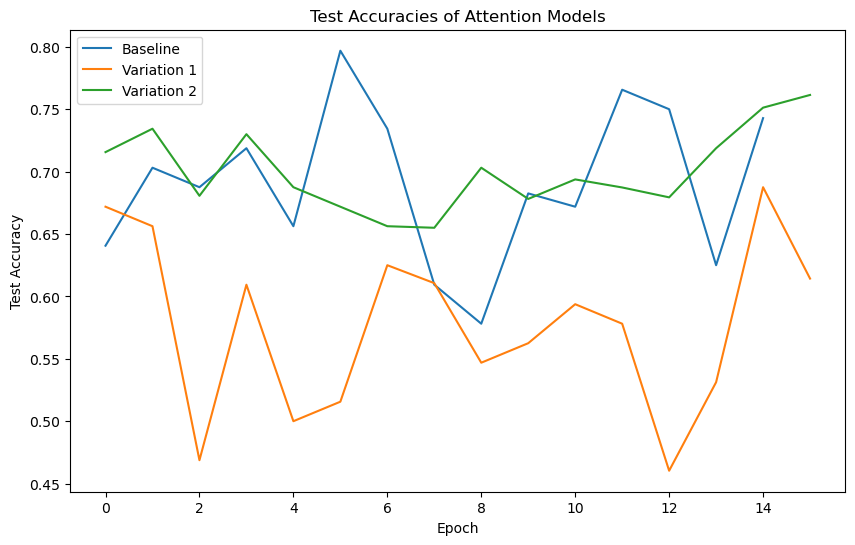

In [319]:
df1 = pd.read_csv('task_B_Baseline_test_accuracy.csv')
df2 = pd.read_csv('task_B_Variation1_test_accuracy.csv')
df3 = pd.read_csv('task_B_Variation2_test_accuracy.csv')

test_accuracy1 = df1['test_accuracy']
test_accuracy2 = df2['test_accuracy']
test_accuracy3 = df3['test_accuracy']

max_length = max(len(test_accuracy1), len(test_accuracy2), len(test_accuracy3))

x = range(max_length)

plt.plot(x[:len(test_accuracy1)], test_accuracy1, label='Baseline')
plt.plot(x[:len(test_accuracy2)], test_accuracy2, label='Variation 1')
plt.plot(x[:len(test_accuracy3)], test_accuracy3, label='Variation 2')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies of Attention Models')
plt.legend()

plt.show()                          

Both the Baseline with dot product attention and the second variation with multiplicative attention show similar performances in terms of accuracy, but the second one, having an additional matrix of parameters (`self.W`) has a slower but smoother learning curve, whereas basic dot product suffers from spikes, as we see in the plot. The first Variation, lacking of the bidirectional GRU layer yields worse performance overall.